----
# Analysis of scRNA-seq data from Vladoiu et al.,

L.Richards  
lauram.richards@mail.utoronto.ca  
Pugh Lab    
April 10, 2020    

/mnt/work1/users/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/Taylor/


----
  
  
**Analysis Plan:** 
1. Download public human medulloblastoma scRNAseq data
2. Cluster cells to generate tSNE using same methods as in Manoranjan et al. (similar to Figure 2)
3. Score cells with GSVA as in Manoranjan et al. Figure 2A
4. Determine significance threshold for cell classification based on gene signature scores
5. Classify cells as Wnt + or Wnt -, as in as in Manoranjan et al. Figure 2b,d

---
# Updated Methods for Manoranjan et al., 2020
---

** Analysis of public scRNA-seq data**

Raw UMI count matrices for 8 (28,268 cells) human medulloblastoma tumour scRNA-seq data were downloaded from [Vladoiu et al.,2019](https://www.ncbi.nlm.nih.gov/pubmed/31043743). Raw counts were log normalized using Seurat. Data scaling, dimensionality reduction and clustering was perfomed as described previously (2814 variable genes, 12 significant PCs) using Seurat. Cells were scored for genes signatures with GSVA and classified as previously described. Microglia/monocytes (AIF1, CD14, CD68) and T cell (CD3G, CD8A, IL7R) clusters were annotated using known gene markers as described in [Vladoiu et al.,2019](https://www.ncbi.nlm.nih.gov/pubmed/31043743).

---
## 1.0 Process Vladoiu et al. Dataset
---

- Taylor Lab provided Seurat objects for each of their tumours
- extract raw count data for each tumour      
- merge raw matrices    
- create metadata using info from manuscript


In [ ]:
setwd("~/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/")

---
### Create merged expression matrix and metadata file

In [ ]:
library("Seurat", 
        lib="/cluster/projects/pughlab/projects/BTSCs_scRNAseq/Manuscript_G607removed/bin/"
       )

suppressPackageStartupMessages({
    #library(GSEABase)
    library(GSVA)
    #library(Biobase)
    library(RColorBrewer)
    library(parallel)
    #library(GSA)
    library(qvalue)
    library(taRifx)
})


loadRData <- function(fileName){
#loads an RData file, and returns it
    load(fileName)
    get(ls()[ls() != "fileName"])
}

In [ ]:
### load in all the objects
### extract raw counts
### update and extract metadata

data.path <- "~/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/Taylor/data/"

files <- list.files(data.path,
                    pattern = "Taylor"
                 )
files


##### create master seurat object
i <- 1


print(files[i])
load.file <- paste0(data.path, files[i])
print(load.file)
merged <- loadRData(load.file)
    
merged@meta.data$Subtype <- unlist(strsplit(files[i], "_"))[4]
merged@meta.data$sampleID <- unlist(strsplit(files[i], "_"))[2]
merged@meta.data$paperID <- unlist(strsplit(files[i], "_"))[3]


##### append all seurat objects together


for (i in 2:length(files)){
    
    print(files[i])
    load.file <- paste0(data.path, files[i])
    print(load.file)
    medullo <- loadRData(load.file)

    medullo@meta.data$Subtype <- unlist(strsplit(files[i], "_"))[4]
    medullo@meta.data$sampleID <- unlist(strsplit(files[i], "_"))[2]
    medullo@meta.data$paperID <- unlist(strsplit(files[i], "_"))[3]
    
    merged <- MergeSeurat(merged, 
                          medullo, 
                          add.cell.id2 = unlist(strsplit(files[i], "_"))[2] 
                         )
    
}

table(merged@meta.data$sampleID)


####### Filter out genes that are 0 across all samples
####### 9040 genes removed, leaves around 23698 genes
####### So many genes, making GSVA really slow, go back in and remove genes in less than 2% of cells
####### about 56 cells for cutoff, leaves 17,178 genes

a <- data.matrix(merged@raw.data) > 0
genes.keep <- rownames(a[rowSums(a) > 56, ])

merged@raw.data <- merged@raw.data[genes.keep, ]
dim(merged@raw.data)

merged <- NormalizeData(object = merged, 
                        normalization.method = "LogNormalize", 
                        scale.factor = 10000
                       )


####### RUN SEURAT ON OBJECT

merged <- FindVariableGenes(object = merged, 
                               mean.function = ExpMean, 
                               dispersion.function = LogVMR, 
                               x.low.cutoff = 0.0125, 
                               x.high.cutoff = 3, 
                               y.cutoff = 0.5
                              )

length(merged@var.genes) #2715 variabe genes

merged <- ScaleData(object = merged, 
                       #vars.to.regress = c("nUMI", "percent.mito")
                      )

merged <- RunPCA(object = merged, 
                    pc.genes = merged@var.genes, 
                    do.print = TRUE, 
                    pcs.print = 1:5,
                    genes.print = 5
                   )

pdf("Merged_elbowPlot_56cellCutoff.pdf")
PCElbowPlot(object = merged) ## 12 PCs
dev.off()

merged <- FindClusters(object = merged, 
                     reduction.type = "pca", 
                     dims.use = 1:12, 
                     resolution = 0.6, 
                     print.output = 0, 
                     save.SNN = TRUE,
                     force.recalc = T
                    )

merged <- RunTSNE(object = merged, 
                     dims.use = 1:12, 
                     do.fast = TRUE
                    )

saveRDS(merged, file = "Vladoiu_Seurat_56cellCutoff.rds")



### Score with GSVA

In [ ]:
#!/bin/bash
#SBATCH -t 72:00:00  #	<-- walltime for your job in format of days-hours:minutes:seconds
#SBATCH --mem=160G    #	<-- amount of memory your job needs to run, in megabytes by default
#SBATCH -p veryhimem     #  <-- partition you job wants to run
#SBATCH -c 30 	     #  <-- number of CPUs your job needs to run
#SBATCH -N 1 	     #  <-- number of nodes your job needs to run. Please use 1 node unless you are running mpi jobs.

###########
### GSVA  on Wnt Gene Signatures
### L.Richards
### April 12, 2020
############

module load R/3.5.0

Rscript ScoreCells_GSVA.R


In [ ]:
##setwd("../GSVA/")

library("Seurat", 
        lib="/cluster/projects/pughlab/projects/BTSCs_scRNAseq/Manuscript_G607removed/bin/"
       )

suppressPackageStartupMessages({
    #library(GSEABase)
    library(GSVA)
    #library(Biobase)
    library(RColorBrewer)
    library(parallel)
    #library(GSA)
    library(qvalue)
    library(taRifx)
})


#### SCORE GENE SIGNATURS WITH GSVA

## load in gene signatures from Singh Lab
#test <- readRDS("../Clustering/Vladoiu_Seurat.rds")
## subset gene signatures to only be Wnt ones to speed things up
print("Load data")
print(Sys.time())

merged <- readRDS("~/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/Taylor/Clustering/Vladoiu_Seurat.rds")

load("~/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/Taylor/GSVA/geneSets_SinghLab.Rdata")
gene.sets <- gene.sets[grep("Wnt", names(gene.sets))]
print(str(gene.sets))

## score genes signatures with GSVA on scaled data matrix 
print("Isolate scaled data matrix")
print(Sys.time())
dat <- data.matrix(merged@scale.data)
print(dim(dat))

print("Score cells with GSVA")
print(Sys.time())
EnrichmentScores <- gsva(expr = dat, 
                         gset.idx.list = gene.sets, 
                         method = "gsva",
                         min.sz = 2, 
                         max.sz = Inf, 
                         mx.diff = TRUE, 
                         verbose = T, 
                         parallel.sz = 25
                        )

print("Save Data")
print(Sys.time())

saveRDS(EnrichmentScores, 
        file = "EnrichmentScores_Taylor_ScaledData.rds"
       )

meta.GSVA <- data.frame(t(EnrichmentScores))

merged <- AddMetaData(merged, 
                         metadata = meta.GSVA
                        )
saveRDS(merged, file = "Vladoiu_Seurat_GSVA.rds")

In [ ]:
### Add tSNE and genes to metadata to save
meta <- merged@meta.data

genes <- c("AIF1", "CD68", "CD14", "CD3G", "IL7R", "CD8A", "PTPRC")
gene.subset <- data.matrix(t(merged@data[genes, ]))

meta <- cbind(meta, gene.subset, merged@dr$tsne@cell.embeddings[ ,1:2])
saveRDS(meta, file = "Vladoiu_Seurat_GSVA_metadata.rds")

---
## 4.0 Classify cells
---

Same method as currently used in Branavans paper. Create 100 random gene lists with same length as gene signature of interest. Score all cells for random gene signatures. Determine a 5% cutoff based on random scores. If gene signature of interset score in a cell surpasses cutoff, it is classified as being "on" for that gene signature.

~/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/GSVA/Random_Sigs

----
### 4.1 Generate 100 random gene sets per gene signature
----

In [ ]:
setwd("./GSVA/RandomSigs")

library("Seurat", 
        lib="/cluster/projects/pughlab/projects/BTSCs_scRNAseq/Manuscript_G607removed/bin/"
       )

suppressPackageStartupMessages({
    #library(GSEABase)
    library(GSVA)
    #library(Biobase)
    library(RColorBrewer)
    library(parallel)
    #library(GSA)
    library(qvalue)
    library(taRifx)
})


### load in data and gene signatures
### subset onlty to Wnt related ones to speed up process

Wnt_medullo <- readRDS("../../Clustering/Vladoiu_Seurat.rds")

load("~/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/Taylor/GSVA/geneSets_SinghLab.Rdata")
gene.sets <- gene.sets[grep("Wnt", names(gene.sets))]
str(gene.sets)

### Generate random gene sets
### 100 gene sets of same length of signature of interest

for (i in 1:length(gene.sets)){
    
    sig.name <- names(gene.sets)[i]
    print(sig.name)
    
    sig.length <- length(gene.sets[[i]])
    print(sig.length)
    
    print("Generating random lists")
    random.sigs <- lapply(1:100, function(x) sample(rownames(Wnt_medullo@data),size = sig.length))
    
    names(random.sigs) <- paste0("Random", 1:100, "_", sig.name)
        
    file1 <- paste0(sig.name, "_Taylor_random_lists.rds")
    print(file1)
    saveRDS(random.sigs, file = file1)
    
}
                        

----
### 4.2.1 Score all cells with scatter random gene signatures
----

This is taking so long on the cluster to run. Instead...
> Break data frame into 1000 smaller dfs
> run script on each one
> will need a wrapper to collect all the results

In [3]:
library("Seurat", 
        lib="/cluster/projects/pughlab/projects/BTSCs_scRNAseq/Manuscript_G607removed/bin/"
       )


print("Load Seurat Data")

### load in data and gene signatures
Wnt_medullo <- readRDS("/cluster/projects/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/Taylor/Clustering/Vladoiu_Seurat.rds")
dat <- as.matrix(Wnt_medullo@scale.data)

####make small dataframes

chunk <- 100 ## how many small dataframes? 100 cells per dataframe
n <- ncol(dat)
r  <- rep(1:ceiling(n/chunk),each=chunk)[1:n]

###break up data frame and save each one as a separate RDS file
### there will be 290 mini dataframes, each with ~100 cells

for (i in 1:max(r)){
    
    print("")
    print("#######")
    print(i)
    index <- r == i
    mini.df <- dat[ ,index]
    print(dim(mini.df))
    file.name <- paste0("MiniDf_", i, ".rds")
    print(file.name)
    saveRDS(mini.df, file = file.name)
    
}

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[223] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[260] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [ ]:
#!/bin/bash
#SBATCH -t 5:00:00  #	<-- walltime for your job in format of days-hours:minutes:seconds
#SBATCH --mem=30G    #	<-- amount of memory your job needs to run, in megabytes by default
#SBATCH -p all    #  <-- partition you job wants to run
#SBATCH -c 30 	     #  <-- number of CPUs your job needs to run
#SBATCH -N 1 	     #  <-- number of nodes your job needs to run. Please use 1 node unless you are running mpi jobs.

###########
### GSVA  on Random Gene Sigs
### L.Richards
### April 8, 2020
############

### $1 is gene signature file
### $2 is expression matrix
### sbatch runGSVA_RandomSigs_scatter.sh Wnt_Subgroup_Taylor_random_lists.rds MiniDf_186.rds

module load R/3.5.0

Rscript GSVA_RandomSigs.R $1 $2


In [ ]:
library("Seurat", 
        lib="/cluster/projects/pughlab/projects/BTSCs_scRNAseq/Manuscript_G607removed/bin/"
       )

suppressPackageStartupMessages({
    #library(GSEABase)
    library(GSVA)
    #library(Biobase)
    library(RColorBrewer)
    library(parallel)
    #library(GSA)
    library(qvalue)
    library(taRifx)
    library(optparse)
})

###############
args <- commandArgs(TRUE)

load.file <- args[1] ##path to random gene sig (_randomlists.rds)
exp.mat <- args[2] ### path to miniDF to read in (minidf.rds)
print(load.file)
print(exp.mat)

######
setwd("/cluster/projects/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/Taylor/GSVA/RandomSigs_scatter/")

print("---------")
print("Load Mini Expression Matrix and Gene Signatures")
print(Sys.time())

### load in data and gene signatures
print(exp.mat)
dat <- readRDS(exp.mat)
print(dim(dat))

###load in random (100) gene signatures
print(load.file)   
random.sigs <- readRDS(load.file)

print("---------")
print("Scoring random lists with GSVA")
print("Scoring on scaled data")
print(Sys.time())

##### GSVA on random sigs 
EnrichmentScores <- gsva(expr = dat, 
                         gset.idx.list = random.sigs, 
                         method = "gsva",
                         min.sz = 2, 
                         max.sz = Inf, 
                         mx.diff = TRUE, 
                         verbose = T, 
                         parallel.sz = 30
                        )

print("---------")
print("Saving GSVA results")
print(Sys.time())
    
filename <- paste0(gsub(".rds", "", exp.mat), "_",
                   gsub("_random_lists.rds", "_GSVA_SCORES.rds", load.file)
                  )
print(filename)
saveRDS(EnrichmentScores, file = filename)
    
print("")
print("")
print("END")
print(Sys.time())

-----
#### Read in all the miniDF GSVA scores and combine into one big dataframe

/cluster/projects/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/Taylor/GSVA/RandomSigs_scatter/GSVA_outs

In [ ]:
#signature <- "Canonical_Wnt_pathway"
signature <- "KEGG_Wnt_pathway_Taylor"
#signature <- "Wnt_Subgroup_Taylor"
files <- list.files(pattern = signature)
length(files)
files[1:10]

masterDF <- readRDS(files[1])


for (i in 2:length(files)){
    
    print("#####")
    print(i)
    print(files[i])
    df <- readRDS(files[i])
    masterDF <- cbind(masterDF, df)
    print(dim(masterDF))
}

print(dim(masterDF))
save.file <- paste0(signature, "_ALL_GSVA_SCORES.rds")
saveRDS(masterDF, save.file)

---
#### 5% Cutoffs for miniDF scores
---

In [ ]:
path <- "/cluster/projects/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/Taylor/GSVA/RandomSigs_scatter/"
files <- list.files(path, pattern = "ALL_GSVA_SCORES.rds")
files

for (i in 1:length(files)){

    load.file <- paste0(path, files[i])
    print(load.file)
    EnrichmentScores <- readRDS(load.file)
    print(dim(EnrichmentScores))
    
    sig.name <- gsub("_ALL_GSVA_SCORES.rds", "", files[i])
    print(sig.name)
    
    bb <- as.vector(as.matrix(EnrichmentScores))
    length(bb)
    
    d <- density(bb)
    cutoff <- qnorm(0.95, mean = mean(bb), sd = sd(bb))

    filename <- paste0(path, sig.name, "_GSVA_RandomListCutoff.pdf")
    print(filename)

    pdf(filename)

    plot_raw <- plot(d,
                 main = paste0(sig.name," - Random Signatures"),
                 xlab = "GSVA Enrichment Score"
                )
    legend("topright",
       legend = c(paste("Mean:", round(mean(bb),3)),
                          paste("Sd:", round(sd(bb), 3)),
                          paste("Cutoff:", round(cutoff,3))
                     ),
               bty = 'n',
               cex = 1
          )
        abline(v=cutoff, lty = 2, col = "red")
dev.off()
    
    
}

---
#### Use cutoffs to classify cells
---

In [ ]:
suppressMessages(library("Seurat", 
                         lib ="/mnt/work1/users/pughlab/projects/BTSCs_scRNAseq/Manuscript/lib/" ))

#### load in Hovestadt seurat object
meta <- readRDS("Vladoiu_Seurat_GSVA_metadata.rds")
colnames(meta)[15:17] <- paste0(colnames(meta)[15:17],"_GSVA")

### Add cutoffs to meta.data
meta$Canonical_Wnt_pathway_Cutoff  <- 0.28
meta$KEGG_Wnt_pathway_Cutoff <- 0.185
meta$Wnt_Subgroup_Cutoff <- 0.382

### Classify data
### 0 = does not pass threshold
### 1 = passes cutoff

meta$Canonical_Wnt_pathway_Classification <- meta$Canonical_Wnt_pathway_GSVA > meta$Canonical_Wnt_pathway_Cutoff
meta$KEGG_Wnt_pathway_Classification <- meta$KEGG_Wnt_pathway_GSVA > meta$KEGG_Wnt_pathway_Cutoff
meta$Wnt_Subgroup_Classification <- meta$Wnt_Subgroup_GSVA > meta$Wnt_Subgroup_Cutoff


### save
saveRDS(meta, file = "Vladoiu_Seurat_GSVA_metadata.rds")

In [ ]:
merged <- FindClusters(object = merged, 
                     reduction.type = "pca", 
                     dims.use = 1:12, 
                     resolution = 0.6, 
                     print.output = 0, 
                     save.SNN = TRUE,
                     force.recalc = TRUE
                    )

colnames(merged@meta.data)[grep("res.0.6", colnames(merged@meta.data))] <- "Cluster_res.0.6"

meta <- readRDS("Vladoiu_Seurat_GSVA_metadata.rds")
meta <- cbind(meta, merged@meta.data[ ,"Cluster_res.0.6"])
colnames(meta)[length(colnames(meta))] <- "Cluster_res.0.6"
saveRDS(meta, file = "Vladoiu_Seurat_GSVA_metadata.rds")

----
### 4.2 Score all cells with random gene signatures
----

This has to happen on H4H because it uses so much memory and it super slow
(submit to himem queue)

In [ ]:
sbatch runGSVA_RandomSigs.sh Wnt_Subgroup_Taylor_random_lists.rds 
sbatch runGSVA_RandomSigs.sh Canonical_Wnt_pathway_Taylor_random_lists.rds
sbatch runGSVA_RandomSigs.sh KEGG_Wnt_pathway_Taylor_random_lists.rds 

---
### 4.3 Define 5% Cutoff for each signatures
---

---
### 4.4 Use cutoffs to classify cells in Hovestadt dataset
---

Canonical_Wnt_Pathway = ####      
KEGG_Wnt_pathway = ####   
Wnt_Subgroup = ####   

---
## 5.0 Plot publication figures
---

Branavan_Hovestadt_Patient_tSNE.pdf
> tSNE colored by patient ID. Samples subgrouped according to methylation results from Hovestadt et al. (Figure 1). All cells are malignant using annotations from Hovestadt et al.

Branavan_Hovestadt_WntSubgroup_tSNE.pdf
> (left) tSNE colored by Wnt subgroup GSVA score    
> (middle) tSNE colored by Wnt subgroup classfication   
> (right) Proportion Wnt Subgroup+ cells across samples  

Branavan_Hovestadt_KEGGWnt_tSNE.pdf
> (left) tSNE colored by KEGG Wnt pathway GSVA score    
> (middle) tSNE colored by KEGG Wnt pathway classfication   
> (right) Proportion KEGG Wnt pathway+ cells across samples  

Branavan_Hovestadt_CanonicalWnt_tSNE.pdf
> (left) tSNE colored by Canonical Wnt Pathway GSVA score    
> (middle) tSNE colored by Canonical Wnt Pathway classfication   
> (right) Proportion Canonical Wnt Pathway+ cells across samples  



/mnt/work1/users/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/figures

In [8]:
setwd("~/Desktop/H4H/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/Taylor/figures")

library(ggplot2)
library(RColorBrewer)

### load in meta.data

file <- "~/Desktop/H4H/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/Taylor/GSVA/Vladoiu_Seurat_GSVA_metadata.rds"
meta <- readRDS(file)
head(meta)
dim(meta)

----
### 5.1 Patient, Subgroup and Cell Annotation tSNE
----

In [14]:
### make custom color paletee
### 5 shades blue = Wnt
### 3 shades red = SHH
### 8 shades orange = GR3
### 9 shades green = GR4

col.pal <- c("#fe9929", #GR3
             "#fee391",
             "#00441b", #GR4
              "#006d2c",
             #"#238b45",
             #"#a1d99b",
             "#74c476",
             "#c7e9c0",
             #"#67000d", #SHH
             "#ef3b2c",
             "#fc9272"
             )
col.pal

[1] "#fe9929" "#fee391" "#00441b" "#006d2c" "#74c476" "#c7e9c0" "#ef3b2c"
[8] "#fc9272"

pdf 
  2

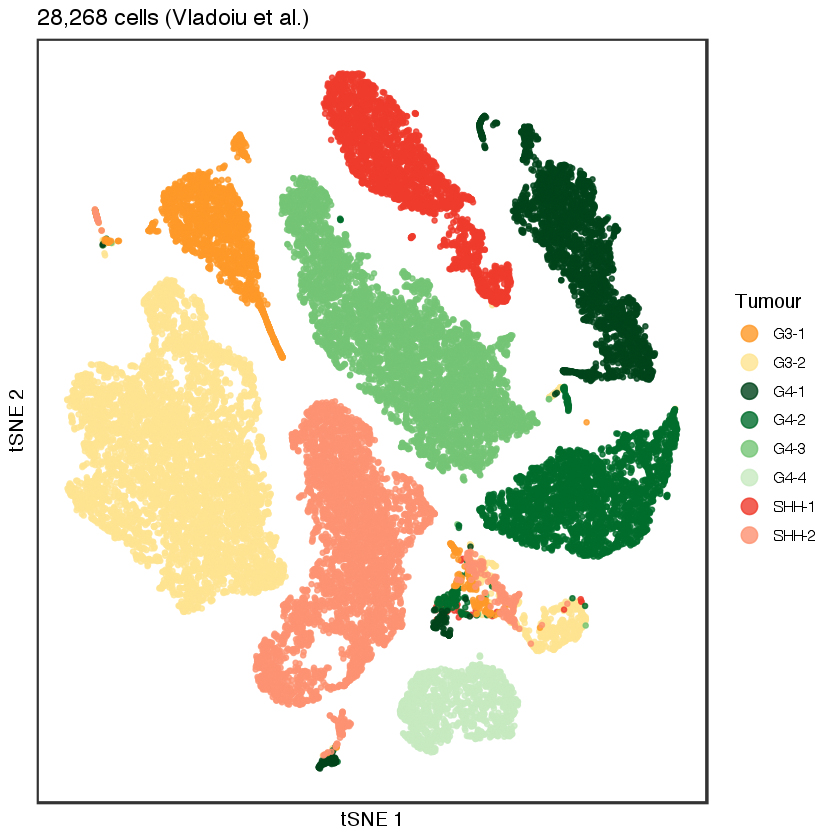

In [29]:
patient.tSNE <- ggplot(meta, aes(x=tSNE_1, y=tSNE_2, color=paperID)) + 
            geom_point(alpha = 0.8, size = 0.8) +  
            labs(x = "tSNE 1", y = "tSNE 2", title = "28,268 cells (Vladoiu et al.)") +
            scale_colour_manual(values = col.pal, name = "Tumour") + 
            theme_bw() + 
            theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank()) + 
                guides(colour = guide_legend(override.aes = list(size=4)))

patient.tSNE

pdf("Branavan_Taylor_Patient_tSNE.pdf", width = 6, height = 6)
patient.tSNE
dev.off()

#### Microglia and T cell markers



In [30]:
genes <- c("AIF1", "CD68", "CD14", "CD3G", "IL7R", "CD8A", "PTPRC")

In [31]:
pdf("Branavan_Taylor_GeneMarkers.pdf", width = 6, height = 6)

for (i in 1:length(genes)){
    
     print(genes[i])
    gene <- ggplot(meta, aes_string(x="tSNE_1", y="tSNE_2", color=genes[i])) + 
        geom_point(alpha = 0.6, size = 1.5) +  
       
         scale_colour_gradientn(colours = rev(brewer.pal(10, "Spectral")), 
                                #limits = c(-0.6,0.6), 
                                name = genes[i]) +
        labs(x = "tSNE 1", y = "tSNE 2", title = "28,268 cells (Vladoiu et al.)") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank())
    print(gene)
}

dev.off()

[1] "AIF1"
[1] "CD68"
[1] "CD14"
[1] "CD3G"
[1] "IL7R"
[1] "CD8A"
[1] "PTPRC"


pdf 
  2

#### Canonical Wnt Pathway


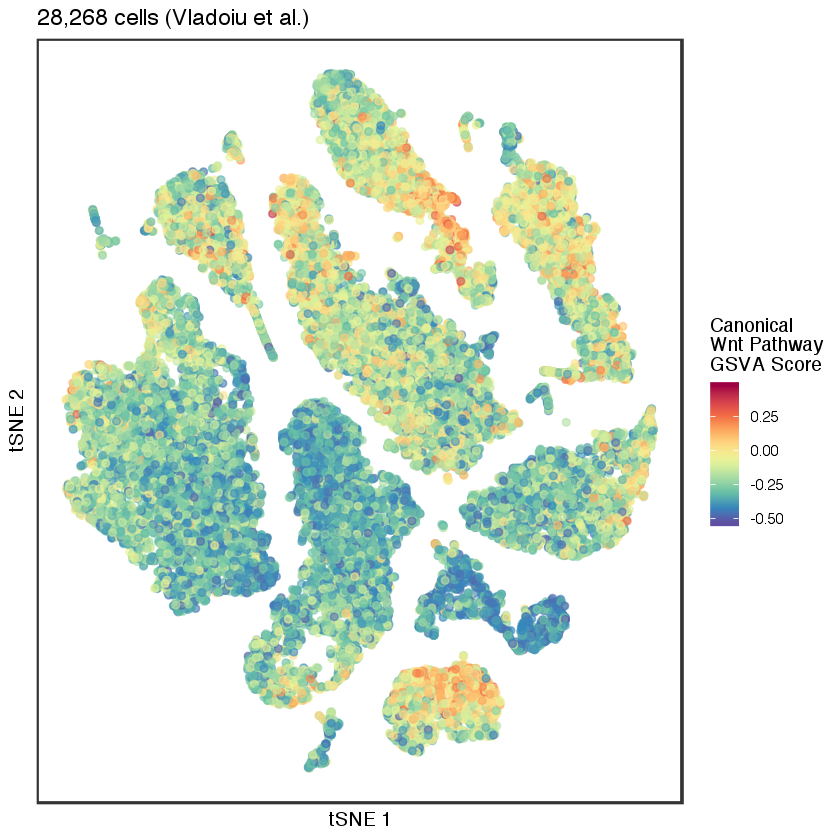

In [5]:
i <- meta$Canonical_Wnt_pathway_GSVA
name <- "Canonical \nWnt Pathway \nGSVA Score"


sp2 <- ggplot(meta, aes(x=tSNE_1, y=tSNE_2, color=i)) + 
        geom_point(alpha = 0.6, size = 1.5) +  
       
         scale_colour_gradientn(colours = rev(brewer.pal(10, "Spectral")), 
                                #limits = c(-0.6,0.6), 
                                name = name) +
        labs(x = "tSNE 1", y = "tSNE 2", title = "28,268 cells (Vladoiu et al.)") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank())
sp2


----
### 5.2 Wnt Subgroup panels
----

- tSNE with GSVA score
- tSNE with classification (binary)
- barplot with classification

In [ ]:
#### load in meta data and erase immune cells
#### immune cells correspond to clusters


In [22]:
setwd("~/Desktop/H4H/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/Taylor/figures/")

In [26]:
library(ggplot2)
library(RColorBrewer)

### load in meta.data

file <- "~/Desktop/H4H/pughlab/projects/SinghLab_scMedullo/Brananvan_Wnt/PublicData_Analysis_April2020/Taylor/GSVA/Vladoiu_Seurat_GSVA_metadata.rds"
meta <- readRDS(file)

## remove immune cell clusters 9 and 14 from viz

meta <- meta[!meta$Cluster_res.0.6 == 9, ]
meta <- meta[!meta$Cluster_res.0.6 == 14, ]
head(meta)
dim(meta)
#table(meta$Cluster_res.0.6)

,nGene,nUMI,orig.ident,res.0.1,res.0.6,res.0.4,res.0.3,res.0.2,Subtype,sampleID,⋯,PTPRC,tSNE_1,tSNE_2,Canonical_Wnt_pathway_Cutoff,KEGG_Wnt_pathway_Cutoff,Wnt_Subgroup_Cutoff,Canonical_Wnt_pathway_Classification,KEGG_Wnt_pathway_Classification,Wnt_Subgroup_Classification,Cluster_res.0.6
AAACCTGAGCTGCCCA,1405,2002.577,SeuratProject,0,0,0,0,0,GR3,BT2016012,⋯,0,-22.99620,-14.059443,0.28,0.185,0.382,FALSE,FALSE,FALSE,0
AAACCTGAGGAGTTGC,1450,2169.153,SeuratProject,0,0,6,0,0,GR3,BT2016012,⋯,0,-27.78681,-6.680690,0.28,0.185,0.382,FALSE,FALSE,FALSE,0
AAACCTGAGTCGCCGT,1567,2060.475,SeuratProject,0,0,2,2,0,GR3,BT2016012,⋯,0,-20.95947,3.363832,0.28,0.185,0.382,FALSE,FALSE,FALSE,0
AAACCTGCATCGGAAG,1493,2128.230,SeuratProject,0,0,1,0,0,GR3,BT2016012,⋯,0,-34.46388,-3.396212,0.28,0.185,0.382,FALSE,FALSE,FALSE,0
AAACCTGCATGGAATA,1626,1994.590,SeuratProject,0,0,1,0,0,GR3,BT2016012,⋯,0,-35.68004,-6.307433,0.28,0.185,0.382,FALSE,FALSE,FALSE,0
AAACCTGCATTCACTT,2172,2322.316,SeuratProject,1,11,3,3,2,GR3,BT2016012,⋯,0,-24.87431,8.955199,0.28,0.185,0.382,FALSE,FALSE,FALSE,11


[1] 26925    33

In [28]:
pdf("Branavan_Taylor_WntSubgroup_tSNE.pdf", width = 6.5, height = 6)

#### 

i <- meta$Wnt_Subgroup_GSVA
name <- "Wnt Subgroup \nGSVA Score"
j <- meta$Wnt_Subgroup_Classification
name2 <- "Wnt Subgroup\nClassification"


sp2 <- ggplot(meta, aes(x=tSNE_1, y=tSNE_2, color=i)) + 
        geom_point(alpha = 0.6, size = 1.5) +  
       
         scale_colour_gradientn(colours = rev(brewer.pal(10, "Spectral")), 
                                #limits = c(-0.6,0.6), 
                                name = name) +
        labs(x = "tSNE 1", y = "tSNE 2", 
             title = "26,925 malignant cells (Vladoiu et al.)") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank())
sp2

#### Cell Classification

sp3 <- ggplot(meta, aes(x=tSNE_1, y=tSNE_2, color=j)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
        #scale_colour_gradientn(colours = c("darkblue", "white", "darkred"), limits = c(-1,1), name = "Wnt Subgroup Score") 
         scale_colour_manual(values = c("grey", '#9E0142'), name = name2) +
        labs(x = "tSNE 1", y = "tSNE 2", 
             title = "26,925 malignant cells (Vladoiu et al.)") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank())

sp3

#### Stacked Barplot

counts <- data.matrix(table(meta$paperID, 
                            meta$Wnt_Subgroup_Classification)
                     )


par(mar=c(10,5,5,5))
barplot(t(counts),
        las = 2,
        col = c("grey", '#9E0142'),
        horiz = F,
        ylab = "Cell Count",
        border = "black",
        main = name2
       )

dev.off()

pdf 
  2

---
### 5.3 KEGG Wnt pathway panels
---

In [29]:
pdf("Branavan_Taylor_KEGGWnt_tSNE.pdf", width = 6.5, height = 6)

#### 

i <- meta$KEGG_Wnt_pathway_GSVA
name <- "KEGG Wnt\nPathway\nGSVA Score"

j <- meta$KEGG_Wnt_pathway_Classification
name2 <- "KEGG Wnt\nPathway\nClassification"

sp2 <- ggplot(meta, aes(x=tSNE_1, y=tSNE_2, color=i)) + 
        geom_point(alpha = 0.6, size = 1.5) +  
       
         scale_colour_gradientn(colours = rev(brewer.pal(10, "Spectral")), 
                                #limits = c(-0.6,0.6), 
                                name = name) +
        labs(x = "tSNE 1", y = "tSNE 2", title = "26,925 malignant cells (Vladoiu et al.)") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank())
sp2

#### Cell Classification

sp3 <- ggplot(meta, aes(x=tSNE_1, y=tSNE_2, color=j)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
        #scale_colour_gradientn(colours = c("darkblue", "white", "darkred"), limits = c(-1,1), name = "Wnt Subgroup Score") 
         scale_colour_manual(values = c("grey", '#9E0142'), name = name2) +
        labs(x = "tSNE 1", y = "tSNE 2", title = "26,925 malignant cells (Vladoiu et al.)") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank())

sp3

#### Stacked Barplot

counts <- data.matrix(table(meta$paperID, 
                            meta$KEGG_Wnt_pathway_Classification)
                     )


par(mar=c(10,5,5,5))
barplot(t(counts),
        las = 2,
        col = c("grey", '#9E0142'),
        horiz = F,
        ylab = "Cell Count",
        border = "black",
        main = name2
       )

dev.off()

pdf 
  2

---
### 5.3 Canonical Wnt Pathway
---

In [31]:
pdf("Branavan_Taylor_CanonicalWnt_tSNE.pdf", width = 6.5, height = 6)

#### 

i <- meta$Canonical_Wnt_pathway_GSVA
name <- "Canonical Wnt\npathway\nGSVA Score"

j <- meta$Canonical_Wnt_pathway_Classification
name2 <- "Canonical Wnt\nPathway\nClassification"

sp2 <- ggplot(meta, aes(x=tSNE_1, y=tSNE_2, color=i)) + 
        geom_point(alpha = 0.6, size = 1.5) +  
       
         scale_colour_gradientn(colours = rev(brewer.pal(10, "Spectral")), 
                                #limits = c(-0.6,0.6), 
                                name = name) +
        labs(x = "tSNE 1", y = "tSNE 2", title = "26,925 malignant cells (Vladoiu et al.)") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank())
sp2

#### Cell Classification

sp3 <- ggplot(meta, aes(x=tSNE_1, y=tSNE_2, color=j)) + 
        geom_point(alpha = 0.45, size = 1.5) +  
        #scale_colour_gradientn(colours = c("darkblue", "white", "darkred"), limits = c(-1,1), name = "Wnt Subgroup Score") 
         scale_colour_manual(values = c("grey", '#9E0142'), name = name2) +
        labs(x = "tSNE 1", y = "tSNE 2", title = "26,925 malignant cells (Vladoiu et al.)") +
        theme_bw() + 
        theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
              panel.border = element_rect(linetype = "solid", fill = NA, size = 1),
              panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank())

sp3

#### Stacked Barplot

counts <- data.matrix(table(meta$paperID, 
                            meta$Canonical_Wnt_pathway_Classification)
                     )


par(mar=c(10,5,5,5))
barplot(t(counts),
        las = 2,
        col = c("grey", '#9E0142'),
        horiz = F,
        ylab = "Cell Count",
        border = "black",
        main = name2
       )

dev.off()

pdf 
  2

----